### 1. Create Vectorized Environment

In [1]:
%load_ext autoreload
%autoreload 2

import gym
import torch
import numpy as np
import time
import os
from datetime import datetime
from gym.wrappers import RecordVideo

from parallelEnv import parallelEnv
from model_ref import Policy
from ppo_ref import ppo_agent
from storage import RolloutStorage
from gym.vector import SyncVectorEnv
from collections import deque
import matplotlib.pyplot as plt
from envs import make_vec_envs
from utils import get_render_func
from torch.utils.tensorboard import SummaryWriter
# from stable_baselines3.common.env_util import make_vec_env
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

debug = True

print('gym version: ', gym.__version__)
print('torch version: ', torch.__version__)
print('cuda version: ', torch.version.cuda)
print('cuda available: ', torch.cuda.is_available())
print("CUDA device count: ", torch.cuda.device_count())
print("Current CUDA device: ", torch.cuda.current_device())

seed = 0 
gamma=0.99
num_processes=16 
device = torch.device("cuda:0")
print('device: ', device)

envs = parallelEnv('Group24M4-v0', n=num_processes, seed=seed)

max_steps = envs.max_steps
print('max_steps: ', max_steps)

if debug:
    action = envs.action_space.sample()
    observation = envs.observation_space.sample()
    ac_size = envs.action_space
    ob_size = envs.observation_space.shape

    print("action", action)
    print("observation", observation)
    print("ac_size", ac_size)
    print("ob_size", ob_size)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

/home/yuku/anaconda3/envs/n5418/lib/python3.8/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment Group24M4-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
2024-11-22 17:59:45.903635: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 17:59:45.944734: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 17:59:46.511185: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


gym version:  0.26.2
torch version:  2.0.0+cu117
cuda version:  11.7
cuda available:  True
CUDA device count:  1
Current CUDA device:  0
device:  cuda:0
max_steps:  1600
action [ 0.0399738   0.95355624 -0.85128564  0.11399261]
observation [ 1.7952703e+00 -2.0129585e+00 -1.3524460e+00  3.0967152e+00
  7.7246961e+04  3.1840581e+03  1.2044232e+00 -7.4241060e-01
  1.2745450e+00  2.3427764e-01  9.9740750e-01 -3.3258388e+00
 -3.5244927e+00  3.9441812e-01  5.1658410e-01  4.4832966e-01
 -5.3259045e-01 -4.4180793e-01  8.4364092e-01 -5.3873080e-01
 -8.6641453e-02 -2.6279038e-01  4.8768610e-02  2.6396534e-01
 -9.6984577e-01 -4.4920944e-02 -6.4089942e-01  8.6034286e-01
 -2.3198789e-02 -3.7896037e-01 -6.3356125e-01  5.5150831e-01
  2.5403255e-01  4.7418647e-02 -2.9252577e-01]
ac_size Box(-1.0, 1.0, (4,), float32)
ob_size (35,)


### 2. Instantiate Model, Agent and Storage

In [2]:
policy = Policy(envs.observation_space.shape, envs.action_space,\
        base_kwargs={'recurrent': True})

if debug:
    print("policy: ", policy)
    print("envs.observation_space.shape: ", envs.observation_space.shape)
    print("envs.action_space: ", envs.action_space)

policy.to(device)

agent = ppo_agent(actor_critic=policy, ppo_epoch=16, num_mini_batch=16,\
                lr=0.001, eps=1e-5, max_grad_norm=0.5)

rollouts = RolloutStorage(num_steps=max_steps, num_processes=num_processes, \
                        obs_shape=envs.observation_space.shape, action_space=envs.action_space, \
                        recurrent_hidden_state_size=policy.recurrent_hidden_state_size)

obs = envs.reset()
print('type obs: ', type(obs), ', shape obs: ', obs.shape)
obs_t = torch.tensor(obs)
print('type obs_t: ', type(obs_t), ', shape obs_t: ', obs_t.shape)

rollouts.obs[0].copy_(obs_t)
rollouts.to(device)


policy:  Policy(
  (base): MLPBase(
    (gru): GRUCell(35, 128)
    (actor): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
    )
    (critic): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
    )
    (critic_linear): Linear(in_features=128, out_features=1, bias=True)
  )
  (dist): DiagGaussian(
    (fc_mean): Linear(in_features=128, out_features=4, bias=True)
    (logstd): AddBias()
  )
)
envs.observation_space.shape:  (35,)
envs.action_space:  Box(-1.0, 1.0, (4,), float32)
type obs:  <class 'numpy.ndarray'> , shape obs:  (16, 35)
type obs_t:  <class 'torch.Tensor'> , shape obs_t:  torch.Size([16, 35])


In [3]:
def save(model, directory, filename, suffix):
    if not os.path.exists(directory):
        os.makedirs(directory)
    torch.save(model.base.actor.state_dict(), '%s/%s_actor_%s.pth' % (directory, filename, suffix))
    torch.save(model.base.critic.state_dict(), '%s/%s_critic_%s.pth' % (directory, filename, suffix))
    torch.save(model.base.critic_linear.state_dict(), '%s/%s_critic_linear_%s.pth' % (directory, filename, suffix))

# limits = [-300, -160, -100, -70, -50, 0, 20, 30, 40, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
limits = [-900, -600, -500, -400, -300, -200, -100, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1010, 1020, 1030, 1040, 1050, 1060]

def return_suffix(j):
    suf = '0'
    for i in range(len(limits)-1):
        if j > limits[i] and j < limits[i+1]:
            suf = str(limits[i+1])
            break
        
        i_last = len(limits)-1    
        if  j > limits[i_last]:
            suf = str(limits[i_last])
            break
    return suf      

In [4]:
num_updates=1000
gamma = 0.99
tau=0.95
save_interval=30
log_interval= 1

# Define the log directory
log_dir = 'runs/ppo_experiment'

# Get the current time as a string for tagging
current_time_tag = datetime.now().strftime('%Y%m%d_%H%M%S')

def ppo_vec_env_train(envs, agent, policy, num_processes, num_steps, rollouts):

    # Create a new SummaryWriter
    writer = SummaryWriter(log_dir=log_dir)
    
    time_start = time.time()
    
    n=len(envs.ps)
    envs.reset()
    
    # start all parallel agents
    print('Number of agents: ', n)
    envs.step([[1]*4]*n)
    
    indices = []
    for i  in range(n):
        indices.append(i)
     
    s = 0
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []

    for i_episode in range(num_updates):
        
        total_reward = np.zeros(n)
        timestep = 0
        
        for timestep in range(num_steps):

            with torch.no_grad():
                value, actions, action_log_prob, recurrent_hidden_states = \
                   policy.act(
                        rollouts.obs[timestep],
                        rollouts.recurrent_hidden_states[timestep],
                        rollouts.masks[timestep])
                
            obs, rewards, done, infos = envs.step(actions.cpu().detach().numpy())
            # obs, rewards, done, truncs, infos = envs.step(actions.cpu().detach().numpy())
            
            total_reward += rewards  ## this is the list by agents
                        
            # If done then clean the history of observations.
            masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
            obs_t = torch.tensor(obs)
            ## Add one dimnesion to tensor, otherwise does not work
            ## This is (unsqueeze(1)) solution for:
            ## RuntimeError: The expanded size of the tensor (1) must match the existing size...
            rewards_t = torch.tensor(rewards).unsqueeze(1)
            rollouts.insert(obs_t, recurrent_hidden_states, actions, action_log_prob, \
                value, rewards_t, masks)
                    
        avg_total_reward = np.mean(total_reward)
        scores_deque.append(avg_total_reward)
        scores_array.append(avg_total_reward)
                
        with torch.no_grad():
            next_value = policy.get_value(rollouts.obs[-1],
                            rollouts.recurrent_hidden_states[-1],
                            rollouts.masks[-1]).detach()

        rollouts.compute_returns(next_value, gamma, tau)

        agent.update(rollouts)

        rollouts.after_update()
        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        # TensorBoard Logging
        writer.add_scalar(f'Average Total Reward/{current_time_tag}', avg_total_reward, i_episode)
        writer.add_scalar(f'Average Score/{current_time_tag}', avg_score, i_episode)
        
        if i_episode > 0 and i_episode % save_interval == 0:
            print('Saving model, i_episode: ', i_episode, '\n')
            suf = return_suffix(avg_score)
            save(policy, 'dir_save', 'we0', suf)

        
        if i_episode % log_interval == 0 and len(scores_deque) > 1:            
            prev_s = s
            s = (int)(time.time() - time_start)
            t_del = s - prev_s
            print('Ep. {}, Timesteps {}, Score.Agents: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02}, \
Interval: {:02}:{:02}'\
                   .format(i_episode, timestep+1, \
                        avg_total_reward, avg_score, s//3600, s%3600//60, s%60, t_del%3600//60, t_del%60)) 

    
        # if len(scores_deque) == 100 and np.mean(scores_deque) > 300.5:   
        # if len(scores_deque) == 100 and np.mean(scores_deque) > 300.0:   
        if len(scores_deque) == 100 and np.mean(scores_deque) > 1050:
        # if np.mean(scores_deque) > 20:   
            print('Environment solved with Average Score: ',  np.mean(scores_deque) )
            break
    
    writer.close()

    return scores_array, avg_scores_array
            

In [5]:
scores, avg_scores = ppo_vec_env_train(envs, agent, policy, num_processes, max_steps, rollouts)

/home/yuku/anaconda3/envs/n5418/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/yuku/anaconda3/envs/n5418/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/yuku/anaconda3/envs/n5418/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/yuku/anaconda3/envs/n5418/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/yuku/anaconda3/envs/n5

Number of agents:  16
Ep. 1, Timesteps 1600, Score.Agents: -9902.13, Avg.Score: -11258.03, Time: 00:00:09, Interval: 00:09
Ep. 2, Timesteps 1600, Score.Agents: -8315.43, Avg.Score: -10277.16, Time: 00:00:14, Interval: 00:05
Ep. 3, Timesteps 1600, Score.Agents: -7727.49, Avg.Score: -9639.75, Time: 00:00:18, Interval: 00:04
Ep. 4, Timesteps 1600, Score.Agents: -5885.95, Avg.Score: -8888.99, Time: 00:00:22, Interval: 00:04
Ep. 5, Timesteps 1600, Score.Agents: -4320.37, Avg.Score: -8127.55, Time: 00:00:27, Interval: 00:05
Ep. 6, Timesteps 1600, Score.Agents: -3962.49, Avg.Score: -7532.54, Time: 00:00:31, Interval: 00:04
Ep. 7, Timesteps 1600, Score.Agents: -2791.60, Avg.Score: -6939.92, Time: 00:00:35, Interval: 00:04
Ep. 8, Timesteps 1600, Score.Agents: -1738.33, Avg.Score: -6361.97, Time: 00:00:40, Interval: 00:05
Ep. 9, Timesteps 1600, Score.Agents: -1699.34, Avg.Score: -5895.71, Time: 00:00:47, Interval: 00:07
Ep. 10, Timesteps 1600, Score.Agents: -1489.44, Avg.Score: -5495.14, Time: 0

In [6]:
save(model=policy,directory='dir_save',filename='we0',suffix='final')

length of scores:  434 , len of avg_scores:  434


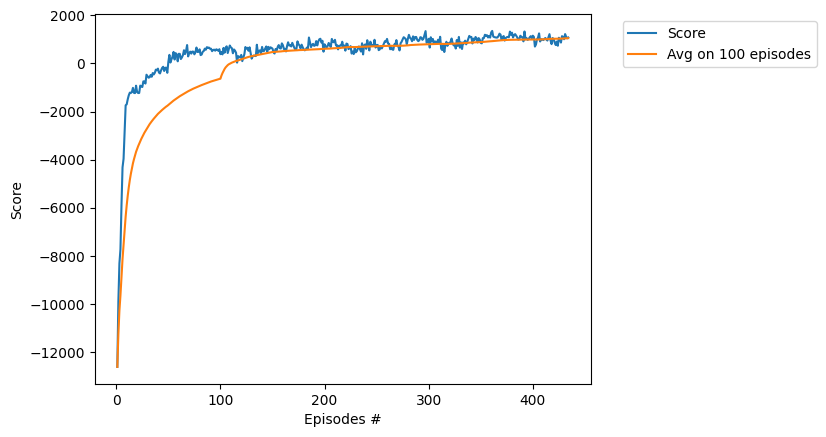

In [7]:
print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [8]:
#--------------- make_vec_envs ----------------
## we continue with the same model, model Policy uses MLPBase, but with new environment env_venv

device = torch.device("cpu")
print('device: ', device)

seed = 0 
num_processes=1

env_venv = make_vec_envs('Group24M4-v0', \
                    seed + 1000, num_processes,
                    None, None, False, device='cpu', allow_early_resets=False)

policy = policy.to(device)

print('env_venv.observation_space.shape: ', env_venv.observation_space.shape, \
      ', len(obs_shape): ', len(env_venv.observation_space.shape))
print('env_venv.action_space: ',  env_venv.action_space, \
      ', action_space.shape[0]: ', env_venv.action_space.shape[0])


device:  cpu
env_venv.observation_space.shape:  (35,) , len(obs_shape):  1
env_venv.action_space:  Box(-1.0, 1.0, (4,), float32) , action_space.shape[0]:  4


In [9]:
# def load(model):
#     model.base.actor.load_state_dict(torch.load('dir_save/we0_actor_final.pth'), strict=True)
#     model.base.critic.load_state_dict(torch.load('dir_save/we0_critic_final.pth'), strict=True)
#     model.base.critic_linear.load_state_dict(torch.load('dir_save/we0_critic_linear_final.pth'), strict=True)
#     # 打印 missing_keys 和 unexpected_keys 信息
#     missing_keys, unexpected_keys = model.base.critic_linear.load_state_dict(torch.load('dir_save/we0_critic_linear_final.pth'), strict=False)
#     print("Missing keys:", missing_keys)
#     print("Unexpected keys:", unexpected_keys)
#     missing_keys, unexpected_keys = model.base.actor.load_state_dict(torch.load('dir_save/we0_actor_final.pth'), strict=False)
#     print("Missing keys:", missing_keys)
#     print("Unexpected keys:", unexpected_keys)
#     missing_keys, unexpected_keys = model.base.critic.load_state_dict(torch.load('dir_save/we0_critic_final.pth'), strict=False)
#     print("Missing keys:", missing_keys)
#     print("Unexpected keys:", unexpected_keys)
#     print("Model loaded successfully.")
   
# policy_300 = Policy(envs.observation_space.shape, envs.action_space,\
#         base_kwargs={'recurrent': True})
# load(model=policy_300)
# policy_300.to(device)
# print("policy_300.recurrent_hidden_state_size", policy_300.recurrent_hidden_state_size)


In [10]:
## No CUDA, only CPU
def play_VecEnv(env, model, num_episodes):

    # 定义视频保存路径
    video_dir = "./videos/"
    os.makedirs(video_dir, exist_ok=True)

    # 将环境包裹在 RecordVideo 中以保存视频
    # env = RecordVideo(env, video_dir, episode_trigger=lambda episode_id: True, render_mode="rgb_array")


    for name, param in model.named_parameters():
        print(name, param)

    obs = env.reset()
    obs = torch.Tensor(obs)
    obs = obs.float()
        
    recurrent_hidden_states = torch.zeros(1, model.recurrent_hidden_state_size)
    
    masks = torch.zeros(1, 1)
    
    scores_deque = deque(maxlen=100)

    render_func = get_render_func(env)
        
    for i_episode in range(1, num_episodes+1):     

        time_start = time.time()
        total_reward = np.zeros(num_processes)
        timestep = 0

        while True:
        
            with torch.no_grad():
                value, action, _, recurrent_hidden_states = \
                    model.act(obs, recurrent_hidden_states, masks, \
                    deterministic=False) # obs = state

            render_func()
            
            obs, reward, done, _ = env.step(action)
            obs = torch.Tensor(obs)
            obs = obs.float()

            reward = reward.detach().numpy()
            
            masks.fill_(0.0 if done else 1.0)
            
            total_reward += reward[0]
        
            #if timestep < 800:
            #    print('timestep: ', timestep, 'reward: ', reward[0])
            
            timestep += 1
            
            if timestep + 1 == 1600: ##   envs.max_steps:
                break

        s = (int)(time.time() - time_start)
        
        scores_deque.append(total_reward[0])
        
        avg_score = np.mean(scores_deque)
                    
        print('Episode {} \tScore: {:.2f}, Avg.Score: {:.2f}, \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, total_reward[0], avg_score,  s//3600, s%3600//60, s%60))
    
    # 关闭环境以确保所有视频文件写入磁盘
    env.close()

In [ ]:
play_VecEnv(env=env_venv, model=policy, num_episodes=3)

base.gru.weight_ih Parameter containing:
tensor([[ 0.1795,  0.0242, -0.0503,  ...,  0.1975,  0.1813,  0.0747],
        [-0.5041,  0.3502,  0.7639,  ..., -0.1784, -0.2410, -0.6223],
        [ 1.2308,  0.9139,  1.2588,  ..., -0.0277, -0.1890, -0.0156],
        ...,
        [-0.4606,  0.2523, -1.1490,  ..., -0.0040,  0.0134, -0.1084],
        [-1.7875,  0.4211,  0.3299,  ..., -0.0836, -0.1513, -0.3833],
        [-0.2794, -1.1350, -1.7452,  ...,  0.3114,  0.4418,  0.3247]],
       requires_grad=True)
base.gru.weight_hh Parameter containing:
tensor([[ 0.0776,  0.0994, -0.0914,  ..., -0.1340, -0.0505, -0.0415],
        [ 0.4774,  0.0467, -0.3430,  ..., -0.3152, -0.4254, -1.0605],
        [-0.1979, -0.2191,  0.3632,  ...,  0.1464,  0.9002,  0.6762],
        ...,
        [-0.2076, -0.2306, -0.5755,  ..., -0.0486,  0.1931, -0.0988],
        [-0.1913,  0.1456, -0.5201,  ...,  0.2149, -0.1317,  0.5885],
        [-0.4057, -0.0349, -0.2413,  ...,  0.3493,  0.2492,  0.3027]],
       requires_grad=Tr

: 

In [12]:
env_venv.close()
obs = env_venv.reset()
env_venv.close()